In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as colors
from matplotlib.patches import Ellipse

In [3]:
# visualization 
color_map_l = colors(['navajowhite', 'skyblue', 'violet'])
color_map_b = colors(['orange', 'dodgerblue', 'purple'])

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


def visualize(means, covariances, mixture_weights, np_array):
    # Visualization
    x = np.linspace(-5, 10, 500)
    y = np.linspace(-5, 10, 500)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    pos = np.empty(X_mesh.shape + (2,))
    pos[:, :, 0] = X_mesh
    pos[:, :, 1] = Y_mesh
    plt.figure(figsize=(10, 6))
    
    # Plot the data points
    plt.scatter(np_array[:, 0], np_array[:, 1], s=10, alpha=0.5)
    
    # # Plot the contours
    # for k in range(len(means)):
    #     rv = mixture_weights[k] * multivariate_normal_pdf(pos, means[k], covariances[k])
    #     plt.contour(X_mesh, Y_mesh, rv, extend='min', colors='green', alpha=0.5)

    # Plot the means
    plt.scatter(means[:, 0], means[:, 1], marker='o', c='red', edgecolor='black', s=100, label='Means')
    
    plt.title('Gaussian Mixture Model for K = {}'.format(len(means)))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    a, b=plt.xlim()
    plt.xlim(-5, 10)
    
    plt.ylim(-5, 5)
    for label_index in range(means.shape[0]):
        plot_cov_ellipse(covariances[label_index], means[label_index], nstd=1, fill=False)
        plot_cov_ellipse(covariances[label_index], means[label_index], nstd=2, fill=False)
        plot_cov_ellipse(covariances[label_index], means[label_index], nstd=3, fill=False)
    plt.show()

# EM Algorithm implementation (GMM - Gaussian Mixture Models)

The GaussianMixtureModel class takes in the no of clusters, maximum iterations and tolerance level. We also have to specify if the algorithm ends on convergences or by completing the number of iterations

Function ```fit```

- Function used to initialize the starting mean, covariance and weights
- It also implements the core iterating loop for the GMM EM algorithm


Function ```_expectation```

- Implements the E step of the algorithm
- It computes the log of the responsibilites (it ensures the smaller values do not cause any errors), from given means and covariance

Function ```_maximization```

- It recomputes the weights, means and covariences (the default convariance type is full) from the given responsibilites 

Function ```_check_convergence```

- It checks wheter the likilihood (log) converged.

In [4]:
class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iters=100, tol=1e-10, to_converge=False):
        # number of clusters
        self.n_components = n_components
        # maximum number of iterations
        self.max_iters = max_iters
        # threshold for convergence
        self.tol = tol
        self.to_converge = to_converge
        
        # model parameters
        self.means = None
        self.covariances = None
        self.mixture_weights = None
        
        # log responsibilities for predictions
        self.log_responsibilities = None
        
        # log-likelihoods for ploting
        self.log_likelihoods = []
        self.iterations = []
        
    def _init_mean_cov_weights(self, X):
        # sort data points on the first feature
        X = X[np.argsort(X[:, 0])]
        # split the data into n_components clusters
        clusters = np.array_split(X, self.n_components)
        # compute the mean of each cluster
        self.means = np.array([cluster.mean(axis=0) for cluster in clusters])        
        # compute the covariance of each cluster
        self.covariances = np.array([np.cov(cluster.T) for cluster in clusters])    
        # compute the mixture weight of each cluster
        self.mixture_weights = np.array([cluster.shape[0] / X.shape[0] for cluster in clusters])    

    def fit(self, X):
        n_samples, n_features = X.shape

        # Step 1: Initialize model parameters
        
        # Randomly initialize means
        # self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self._init_mean_cov_weights(X)
        # Randomly initialize covariances
        # self.covariances = np.array([np.eye(n_features)] * self.n_components)
        # Randomly initialize mixture weights
        # self.mixture_weights = np.full(self.n_components, 1 / self.n_components)

        # EM algorithm
        for i in range(self.max_iters):
            # Step 2: E-step
            log_responsibilities = self._expectation(X)

            # Step 3: M-step
            self._maximization(X, np.exp(log_responsibilities))
            
            self.iterations.append(i)
            self.log_likelihoods.append(self.log_likelihood)
            self.log_responsibilities = log_responsibilities
            
            # Check for convergence
            if self.to_converge and self._check_convergence(X, np.exp(log_responsibilities)):
                break
            
    def predict(self, X):
        return np.argmax(self.log_responsibilities, axis=1)
                    
            
    def _expectation(self, X):        
        log_responsibilities = np.zeros((X.shape[0], self.n_components))
        
        for i in range(X.shape[0]):
            for j in range(self.n_components):
                log_responsibilities[i][j] =  np.log(self.mixture_weights[j]) + self._log_multivariate_gaussian(X[i], self.means[j], self.covariances[j])
        
        self.log_likelihood = np.sum(np.log(np.sum(np.exp(log_responsibilities), axis=1)))
        
        log_resp_norm = np.log(np.linalg.norm(np.exp(log_responsibilities), axis=1, ord = 1, keepdims=True))
        log_responsibilities -= log_resp_norm

        return log_responsibilities
    
    def _log_multivariate_gaussian(self, x, mean, cov):
        return -0.5 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean) - 0.5 * np.log(np.linalg.det(cov)) - 0.5 * np.log(2 * np.pi) * x.shape[0]
    
    def _maximization(self, X, responsibilities):
        class_responsibilities = np.sum(responsibilities, axis=0) + 10 * np.finfo(responsibilities.dtype).eps
        
        # update means
        self.means = np.dot(responsibilities.T, X) / class_responsibilities[:, np.newaxis]
        # update weights
        self.mixture_weights = class_responsibilities / X.shape[0]
        # update covariances
        for c in range(self.n_components):
            diff = X - self.means[c]
            self.covariances[c] = np.dot(responsibilities[:,c] * diff.T, diff) / class_responsibilities[c]
            self.covariances[c].flat[::X.shape[1] + 1] += 1e-6

    def _get_log_likelihood(self, resp):
        return np.sum(np.log(np.sum(resp, axis=1)))

    def _check_convergence(self, X, resp):
        # Check for convergence based on the change in log-likelihood
        if hasattr(self, 'prev_log_likelihood') and np.abs(self.log_likelihood- self.prev_log_likelihood) < self.tol:
            return True
        else:
            self.prev_log_likelihood = self.log_likelihood
            return False

In [7]:
# Read the data
df = pd.read_csv('Dataset for PRML PA2/Dataset4/A2Q3.csv')
# get the data into numpy array
np_array = df.values

# Visual Analysis

From the scatter plot we can see that the data points seems to form three different clusters.

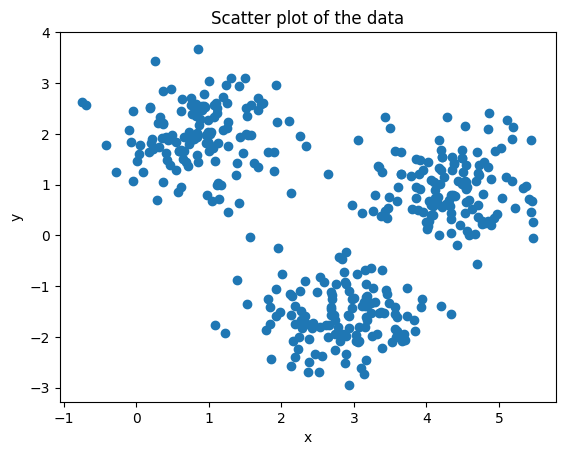

In [9]:
#plot the data
plt.scatter(np_array[:,0],np_array[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of the data')
plt.show()

Means: [[ 0.88603284  1.96201816]
 [ 2.82073682 -1.58884092]
 [ 4.32027304  0.93976986]]
Covariances: [[[ 0.35248661  0.00536329]
  [ 0.00536329  0.40084146]]

 [[ 0.37819788  0.00253068]
  [ 0.00253068  0.2945098 ]]

 [[ 0.34103191 -0.00421464]
  [-0.00421464  0.35809181]]]
Mixture Weights: [0.33552765 0.32886489 0.33560746]


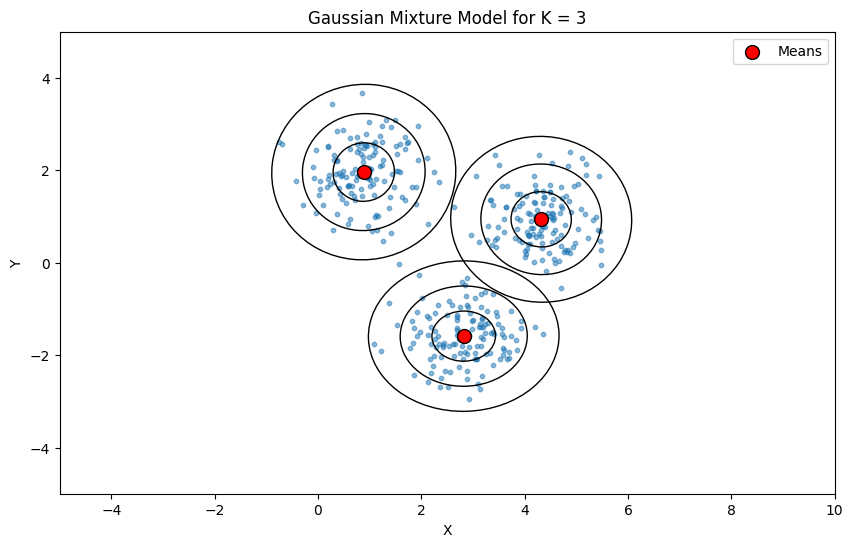

In [128]:
# Create and fit GMM
gmm = GaussianMixtureModel(n_components=3)
gmm.fit(np_array)

# Get estimated model parameters
print("Means:", gmm.means)
print("Covariances:", gmm.covariances)
print("Mixture Weights:", gmm.mixture_weights)
visualize(gmm.means, gmm.covariances, gmm.mixture_weights, np_array)

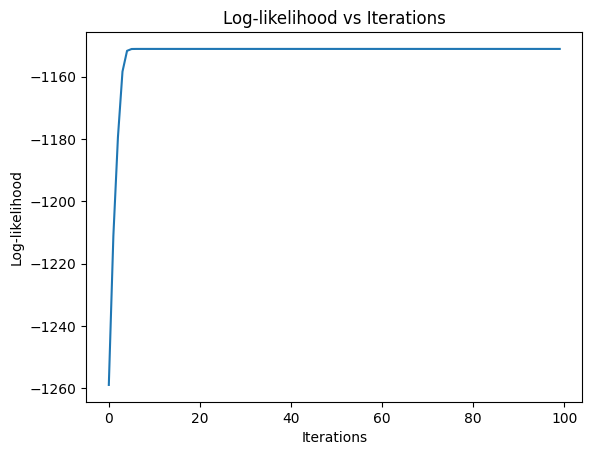

In [129]:
gmm = GaussianMixtureModel(n_components=3, max_iters=100)
gmm.fit(np_array)
plt.plot(gmm.iterations, gmm.log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs Iterations')
plt.show()

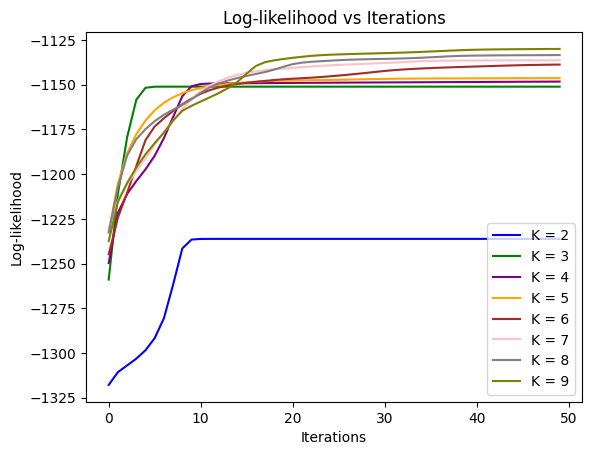

In [130]:
# plot the log-likelihoods vs iterations

# color list from viridis
color_list = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for k in range(2, 10):
    gmm = GaussianMixtureModel(n_components=k, max_iters=50)
    gmm.fit(np_array)
    plt.plot(gmm.iterations, gmm.log_likelihoods, label='K = {}'.format(k), color=color_list[k-1])
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs Iterations')
plt.legend()
plt.show()

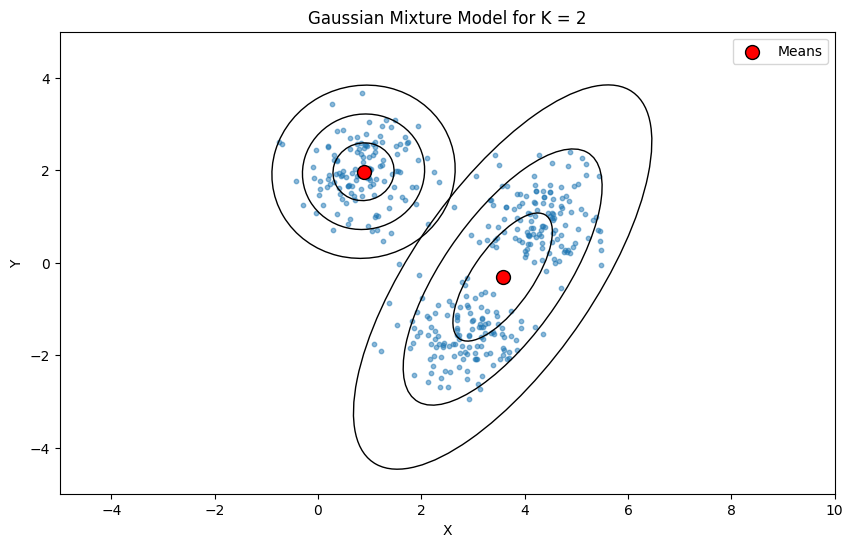

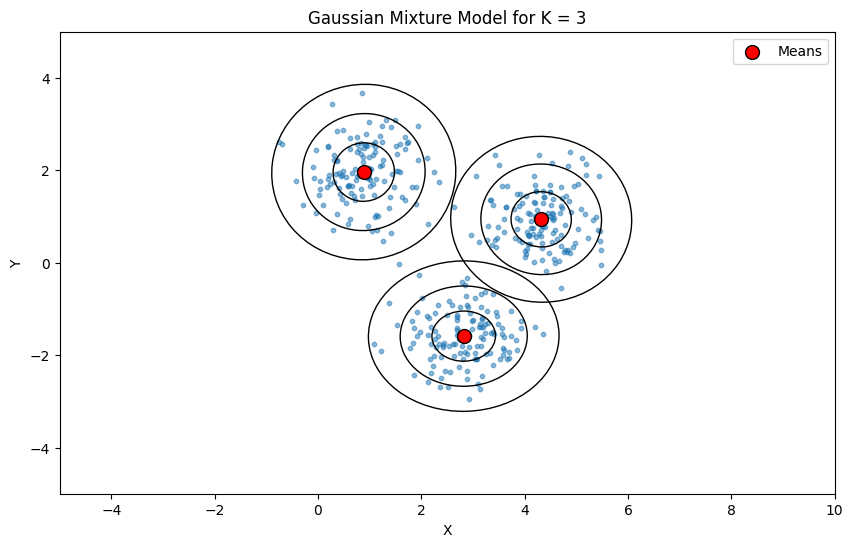

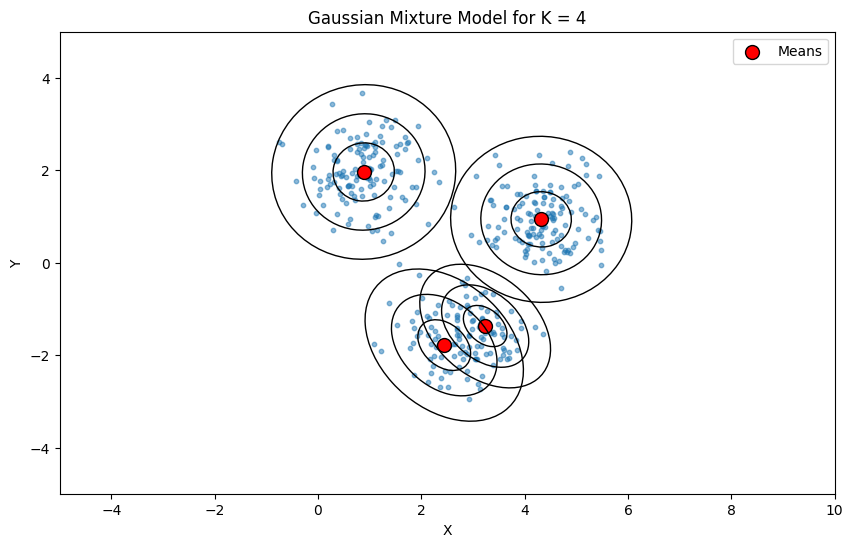

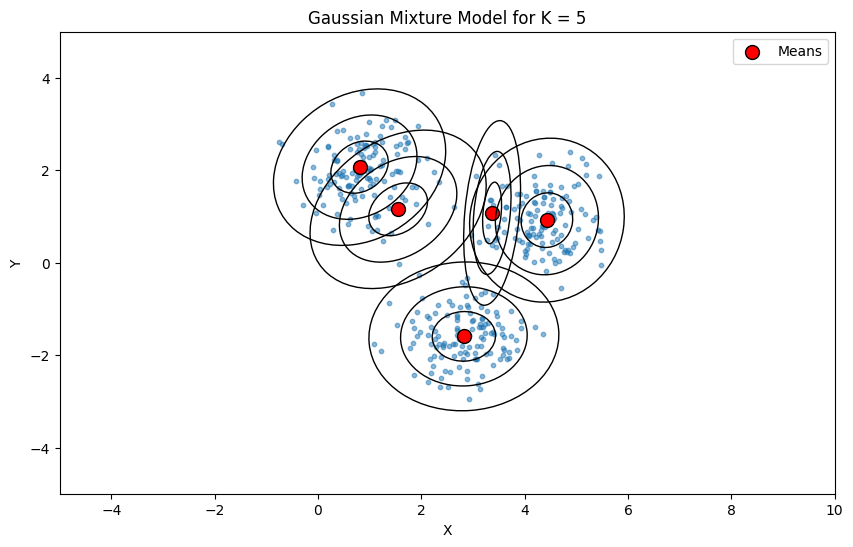

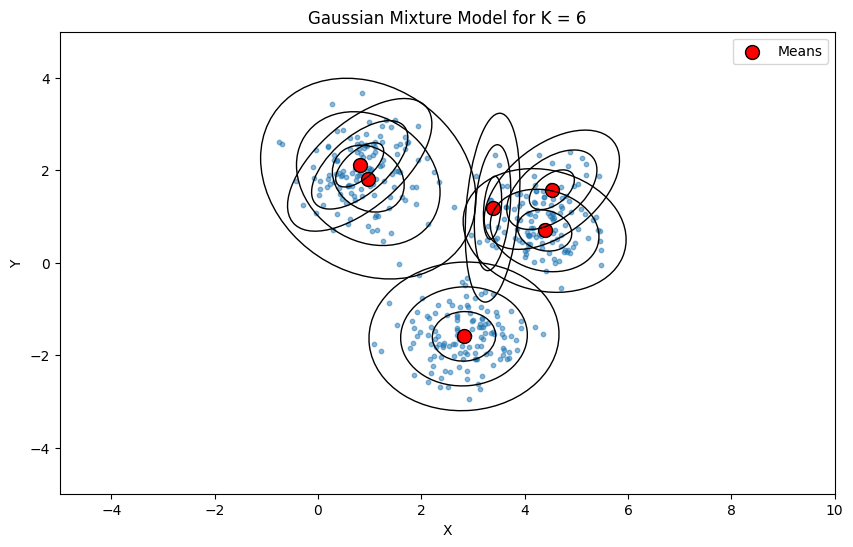

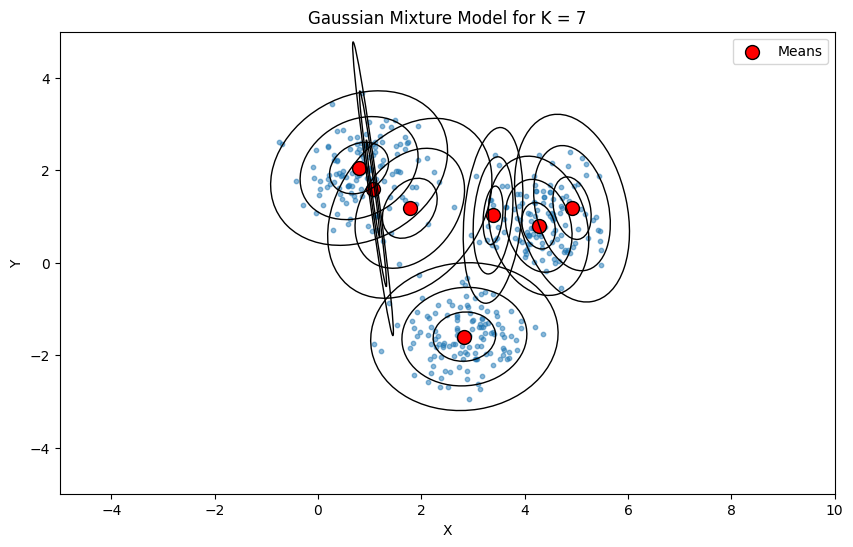

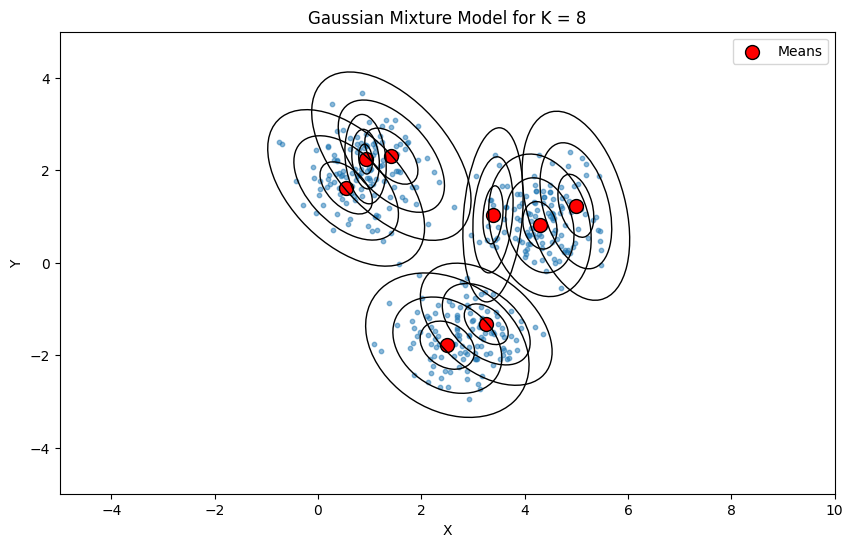

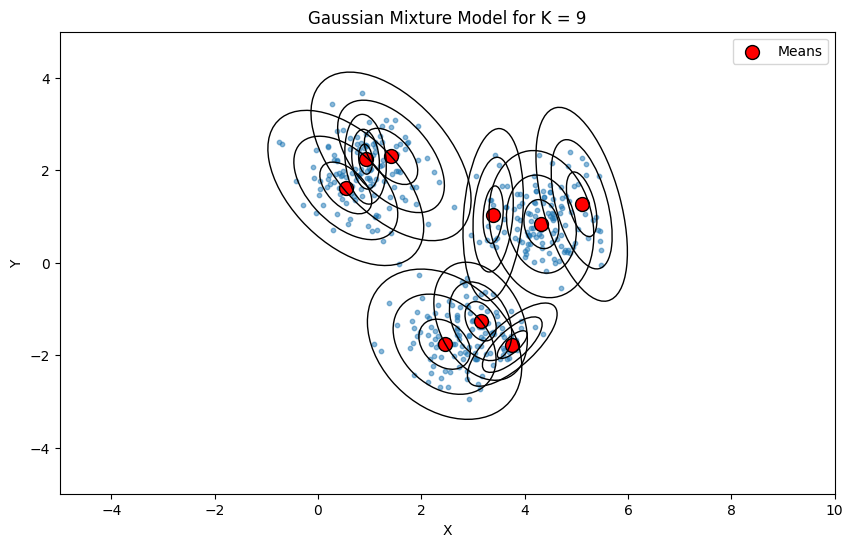

In [114]:
# running for various values of k
for i in range(2, 10):
    gmm = GaussianMixtureModel(n_components=i)
    gmm.fit(np_array)
    visualize(gmm.means, gmm.covariances, gmm.mixture_weights, np_array)

# Best Model

This part uses various algorithms which tells us for which value of K, our EM Algorithm fits and predicts better.

The Silhouette score measures the similarity of each data point to its assigned cluster, and ranges from -1 to 1, with higher scores indicating better clustering. A high Silhouette score indicates that the data points within each cluster are tightly packed, and well separated from other clusters. In the case where K=3, the Silhouette score for each data point is relatively high, indicating that each cluster is well defined and compact.

On the other hand, the BIC score measures the tradeoff between model complexity and goodness-of-fit to the data. Lower BIC scores indicate a better tradeoff between these two factors. A GMM model with three components provides a good balance between capturing the underlying structure of the data and avoiding overfitting.

Therefore, based on both the Silhouette score and BIC score, a GMM model with three components is the optimal choice for this dataset.This means that a GMM model with three components provides the best balance between model complexity and goodness-of-fit to the data.

## Silhoutte score

Silhouette score for k = 2 is 0.5469534238072584
Silhouette score for k = 3 is 0.6581001211108048
Silhouette score for k = 4 is 0.5372332558145442
Silhouette score for k = 5 is 0.42208395713864666
Silhouette score for k = 6 is 0.3514527549196965
Silhouette score for k = 7 is 0.3627027361248889
Silhouette score for k = 8 is 0.23919888267302447
Silhouette score for k = 9 is 0.21835193017579946


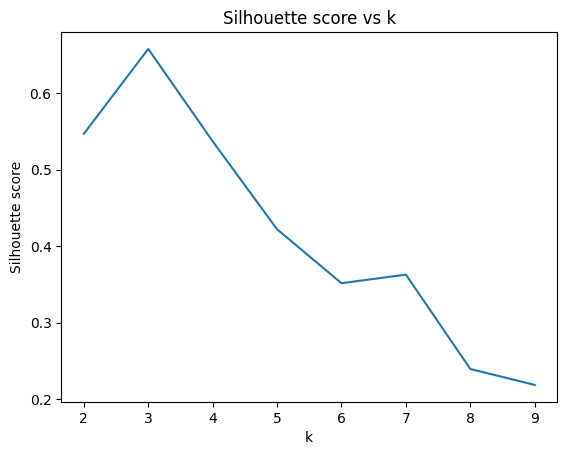

In [13]:
# Silhouette score
from sklearn.metrics import silhouette_score

_k = []
scores = []

for k in range(2, 10):
    gmm = GaussianMixtureModel(n_components=k)
    gmm.fit(np_array)
    labels = gmm.predict(np_array)
    
    score = silhouette_score(np_array, labels)
    scores.append(score)
    _k.append(k)
    print("Silhouette score for k = {} is {}".format(k, score))
    
plt.plot(_k, scores)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs k')
plt.show()

BIC score for k = 2 is 2544.2081164711853
BIC score for k = 3 is 2409.9571664067525
BIC score for k = 4 is 2439.0006975752945
BIC score for k = 5 is 2472.0944264823634
BIC score for k = 6 is 2490.844138449742
BIC score for k = 7 is 2523.6998809069264
BIC score for k = 8 is 2553.2527724051233
BIC score for k = 9 is 2580.0119454252654


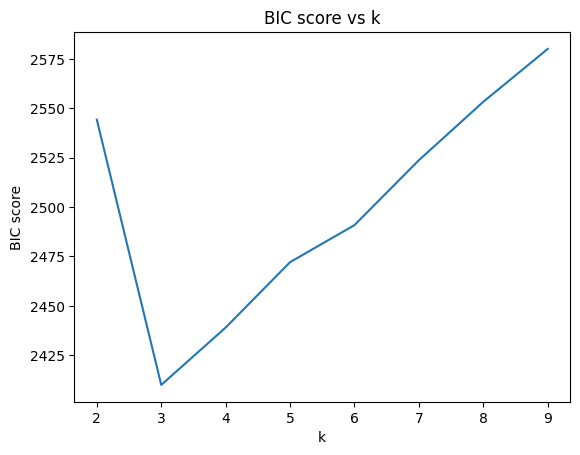

In [14]:
# BIC
log_likelihoods = []
n_params = []
n_features = np_array.shape[1]
for k in range(2, 10):
    gmm = GaussianMixtureModel(n_components=k)
    gmm.fit(np_array)
    log_likelihoods.append(gmm.log_likelihood)
    n_params.append(k * (n_features + n_features * (n_features + 1) / 2 + 1))

n_data = np_array.shape[0]
bic_scores = []

for i in range(len(log_likelihoods)):
    bic = n_params[i] * np.log(n_data) - 2 * log_likelihoods[i]
    bic_scores.append(bic)
    print("BIC score for k = {} is {}".format(i+2, bic))
    
plt.plot(_k, bic_scores)
plt.xlabel('k')
plt.ylabel('BIC score')
plt.title('BIC score vs k')
plt.show()

Distance between GMMs with k = 2 and k = 3 is 0.1671718715188012
Distance between GMMs with k = 2 and k = 4 is 0.25000000000000006
Distance between GMMs with k = 2 and k = 5 is 0.30000000000000004
Distance between GMMs with k = 2 and k = 6 is 0.3333333333333334
Distance between GMMs with k = 2 and k = 7 is 0.35714285714285726
Distance between GMMs with k = 2 and k = 8 is 0.37500000000000006
Distance between GMMs with k = 2 and k = 9 is 0.38888888888888895
Distance between GMMs with k = 3 and k = 4 is 0.0833333333333333
Distance between GMMs with k = 3 and k = 5 is 0.1333333333333333
Distance between GMMs with k = 3 and k = 6 is 0.16666666666666669
Distance between GMMs with k = 3 and k = 7 is 0.19047619047619044
Distance between GMMs with k = 3 and k = 8 is 0.2083333333333333
Distance between GMMs with k = 3 and k = 9 is 0.22222222222222215
Distance between GMMs with k = 4 and k = 5 is 0.080690269227462
Distance between GMMs with k = 4 and k = 6 is 0.10555188942111106
Distance between 

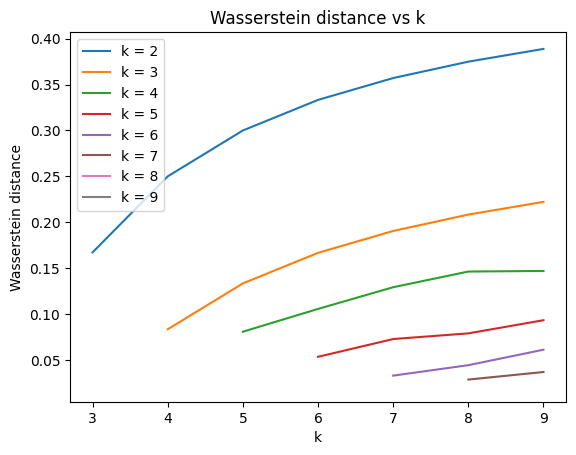

In [54]:
# distances between the GMM models
from scipy.stats import wasserstein_distance


for i in range(2, 10):
    gmm1 = GaussianMixtureModel(n_components=i)
    gmm1.fit(np_array)
    distances = []
    for j in range(i+1, 10):
        gmm2 = GaussianMixtureModel(n_components=j)
        gmm2.fit(np_array)
        distances.append(wasserstein_distance(gmm1.mixture_weights, gmm2.mixture_weights))
        print("Distance between GMMs with k = {} and k = {} is {}".format(i, j, distances[-1]))
    plt.plot(range(i+1, 10), distances, label='k = {}'.format(i))

plt.xlabel('k')
plt.ylabel('Wasserstein distance')
plt.title('Wasserstein distance vs k')
plt.legend();
plt.show()